# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 17.9MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Sun Jan 31 16:50:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/Data/nlp'
os.listdir(data_dir)

['ko_32000.model', 'ko_32000.vocab', 'kowiki', 'nsmc']

In [7]:
# nsmc dir
nsmc_dir = os.path.join(data_dir, 'nsmc')
if not os.path.exists(nsmc_dir):
    os.makedirs(nsmc_dir)
os.listdir(nsmc_dir)

['ratings_test.txt', 'ratings_train.txt', 'stub.csv', 'stub.hdf5']

# Vocabulary & config

In [8]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [9]:
n_vocab = len(vocab)  # number of vocabulary
n_seq = 47  # number of sequence
d_model = 256  # dimension of model
n_out = 2  # number of output class

# 모델링

In [23]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    문장의 감정분류 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    ################################
    # RNN / CNN 등을 추가해 보세요.

    conv_1 = tf.keras.layers.Conv1D(filters=128, kernel_size =3, padding='causal')
    hidden = conv_1(hidden)

    #rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=128, return_sequences=True))
    #hidden = rnn_1(hidden)

    ################################
    # 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool = pool(hidden)  # (bs, d_model)
    # 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
    linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    outputs = linear(hidden_pool)  # (bs, n_out)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# All Data Project

## Data


In [24]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [25]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [26]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [27]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [28]:
def load_data(df, n_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_seq: number of sequence
    :return inputs: input data
    :return labels: label data
    """
    inputs = np.zeros((len(df), n_seq)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        label = row['label']
        document = row['document']
        # print(label, document)
        tokens = vocab.encode_as_pieces(document)
        # print(len(tokens), ':', tokens)
        token_ids = vocab.encode_as_ids(document)
        # print(len(token_ids), ':', token_ids)
        token_ids = token_ids[:n_seq]
        # print(len(token_ids), ':', token_ids)
        token_ids += [0] * (n_seq - len(token_ids))
        # print(len(token_ids), ':', token_ids)

        labels[index] = label
        inputs[index] = token_ids
        index += 1
    return inputs, labels

In [29]:
# train data 생성
train_inputs, train_labels = load_data(df_train, n_seq)
train_inputs, train_labels

(array([[  188, 16337,     7, ...,     0,     0,     0],
        [15825,     7,     7, ...,     0,     0,     0],
        [ 2329,   349,     1, ...,     0,     0,     0],
        ...,
        [   29,   128, 19999, ...,     0,     0,     0],
        [14943,  7071,   802, ...,     0,     0,     0],
        [  253,   321,  1071, ...,     0,     0,     0]], dtype=int32),
 array([0., 1., 0., ..., 0., 1., 0.]))

In [30]:
# test data 생성
test_inputs, test_labels = load_data(df_test, n_seq)
test_inputs, test_labels

(array([[ 5441,    10, 31026, ...,     0,     0,     0],
        [  618,   509,   798, ...,     0,     0,     0],
        [19999,   173,    29, ...,     0,     0,     0],
        ...,
        [ 2087,    32, 22687, ...,     0,     0,     0],
        [ 3991, 27855,    11, ...,     0,     0,     0],
        [ 4404,    11,   375, ...,     0,     0,     0]], dtype=int32),
 array([1., 0., 0., ..., 0., 0., 0.]))

## 학습

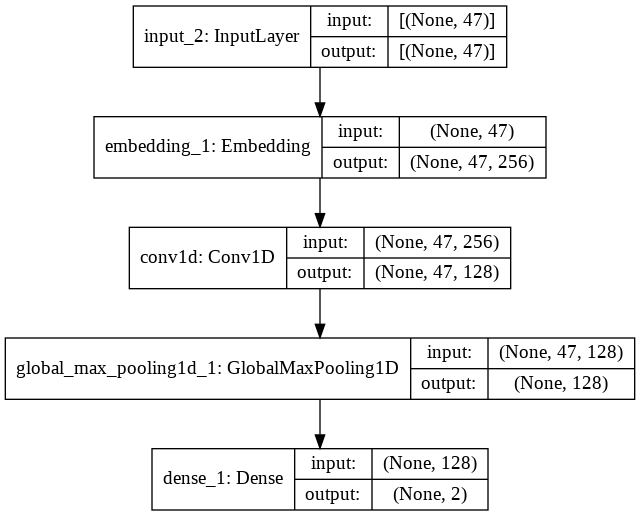

In [31]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [32]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'stub.hdf5'),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'stub.csv'))

In [34]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
586/586 [==============================] - 58s 90ms/step - loss: 0.4516 - accuracy: 0.7924 - val_loss: 0.3351 - val_accuracy: 0.8551

Epoch 00001: val_accuracy improved from -inf to 0.85511, saving model to /content/drive/MyDrive/Data/nlp/nsmc/stub.hdf5
Epoch 2/100
586/586 [==============================] - 52s 89ms/step - loss: 0.2606 - accuracy: 0.8966 - val_loss: 0.3236 - val_accuracy: 0.8618

Epoch 00002: val_accuracy improved from 0.85511 to 0.86181, saving model to /content/drive/MyDrive/Data/nlp/nsmc/stub.hdf5
Epoch 3/100
586/586 [==============================] - 52s 89ms/step - loss: 0.1672 - accuracy: 0.9416 - val_loss: 0.3455 - val_accuracy: 0.8595

Epoch 00003: val_accuracy did not improve from 0.86181
Epoch 4/100
586/586 [==============================] - 52s 88ms/step - loss: 0.0965 - accuracy: 0.9711 - val_loss: 0.3990 - val_accuracy: 0.8551

Epoch 00004: val_accuracy did not improve from 0.86181
Epoch 5/100
586/586 [==============================] - 52s 88ms

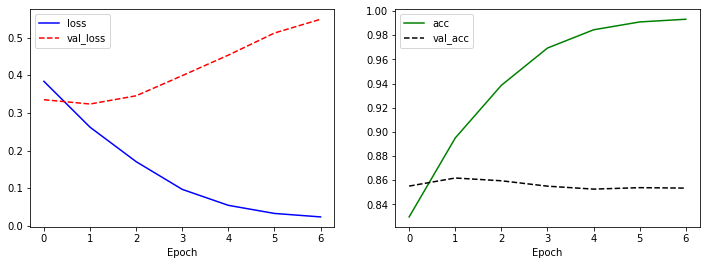

In [35]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [36]:
# 모델 생성
model = build_model(n_vocab, d_model, n_seq, n_out)
# train weight로 초기화
model.load_weights(os.path.join(nsmc_dir, 'stub.hdf5'))

In [37]:
# 예측
logits = model.predict(test_inputs)
logits

array([[3.6765177e-02, 9.6323484e-01],
       [2.8985709e-01, 7.1014291e-01],
       [1.7026830e-01, 8.2973170e-01],
       ...,
       [2.4732551e-02, 9.7526747e-01],
       [9.9905497e-01, 9.4501383e-04],
       [2.8486776e-01, 7.1513224e-01]], dtype=float32)

In [38]:
# 확률 최대 값을 예측으로 사용
test_preds = np.argmax(logits, axis=-1)
test_preds

array([1, 1, 1, ..., 1, 0, 1])

In [39]:
confusion_matrix = np.zeros((n_out, n_out)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

array([[21039,  3787],
       [ 3122, 22049]])

In [40]:
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.8618117087025221
precision: 0.8534215822882799
recall: 0.8759683763060665
f1: 0.8645480032152449


In [41]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 입력 개수
    :param string: 입력 문자열
    """
    # token 생성: <string tokens>, [PAD] tokens
    token = vocab.encode_as_ids(string)[:n_seq]
    token += [0] * (n_seq - len(token))
    token = token[:n_seq]

    y_pred = model.predict(np.array([token]))
    y_pred_class = K.argmax(y_pred, axis=-1)

    return "긍정" if y_pred_class[0] == 1 else "부정"

In [43]:
while True:
    print("input > ", end="")
    string = str(input())
    if len(string) == 0:
        break
    print(f"output > {do_predict(model, n_seq, string)}")

input > 와 정말 인생영화였어요
output > 긍정
input > 
